# Installing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.applications import mobilenet
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import datasets, layers, models


#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
tf.keras.backend.clear_session()

# Preprocessing

**Our Train and Test Path**

In [3]:
train_path = './Covid19-dataset/train'
test_path = './Covid19-dataset/test'

**Getting the labels of the data**

**Our images are of varying sizes but all of them are greater than (512,512) so I have used 512,512 as the size for training our model**

In [4]:
img_size = 224
batch = 16

# Image Loader

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(img_size, img_size),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

In [7]:
train_generator = generate_data(train_path)

test_generator = generate_data(test_path)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Modelling

In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

### Overview of our entire model

In [9]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

## Callback to save our best model during training

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [11]:
opt = Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training the Model

In [12]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = True,
                   callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 19s 908ms/step - loss: 1.4240 - accuracy: 0.5498 - val_loss: 0.5991 - val_accuracy: 0.7273
Epoch 2/100
16/16 [==============================] - 13s 811ms/step - loss: 0.3056 - accuracy: 0.9004 - val_loss: 0.3655 - val_accuracy: 0.8485
Epoch 3/100
16/16 [==============================] - 12s 784ms/step - loss: 0.1901 - accuracy: 0.9402 - val_loss: 0.3615 - val_accuracy: 0.8485
Epoch 4/100
16/16 [==============================] - 13s 790ms/step - loss: 0.1670 - accuracy: 0.9402 - val_loss: 0.2323 - val_accuracy: 0.9091
Epoch 5/100
16/16 [==============================] - 12s 785ms/step - loss: 0.1006 - accuracy: 0.9801 - val_loss: 0.2102 - val_accuracy: 0.9242
Epoch 6/100
16/16 [==============================] - 13s 785ms/step - loss: 0.0902 - accuracy: 0.9761 - val_loss: 0.1793 - val_accuracy: 0.9242
Epoch 7/100
16/16 [==============================] - 12s 757ms/step - loss: 0.0737 - accuracy: 0.9880 - val_loss: 0.1916 - val_accuracy:

# Evaluation

In [13]:
from tensorflow.keras.models import load_model

In [14]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Loading our best model

In [15]:
model = load_model('./model.hdf5')

In [16]:
def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

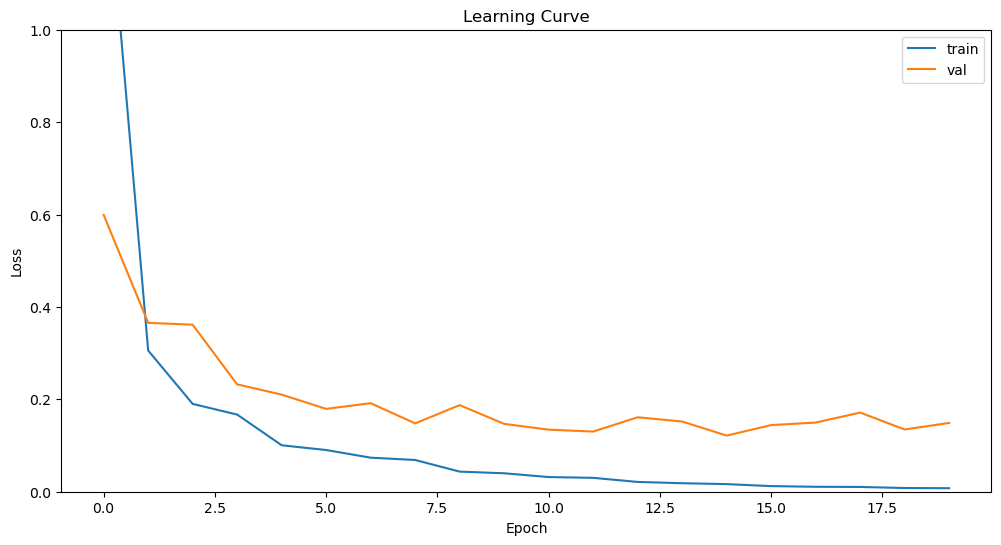

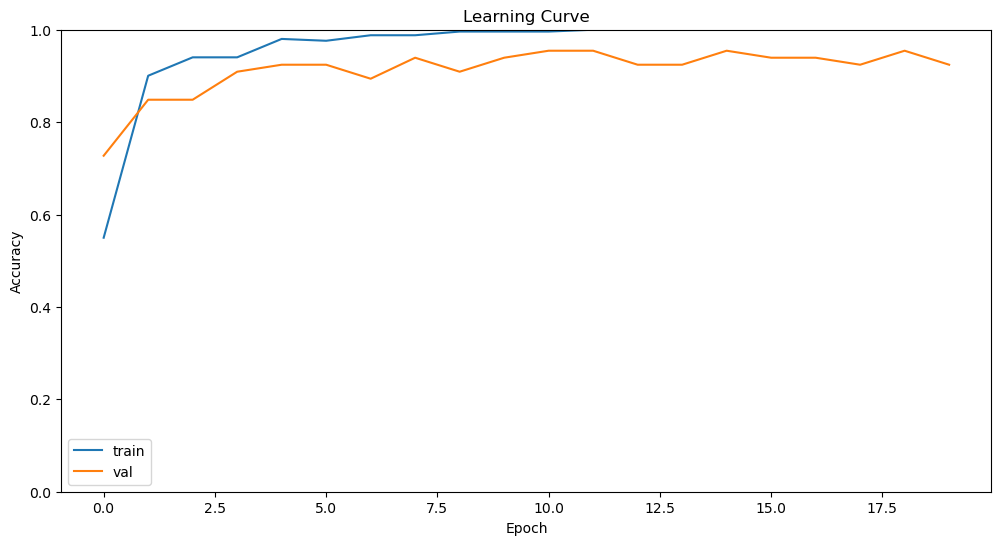

In [17]:
learning_curve(history,'loss', ylim=(0,1))
learning_curve(history, 'accuracy', ylim=(0,1))

In [18]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

5/5 [==============================] - 4s 321ms/step - loss: 0.1215 - accuracy: 0.9545
Loss: 12.152
Accuracy: 95.455


**We got a good model with an accuracry of 95%**

In [19]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

5/5 [==============================] - 3s 332ms/step


(array([2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1,
        0, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2,
        2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [20]:
classes = []
for i in os.listdir(test_path):
    classes+=[i]

classes

['Covid', 'Normal', 'Viral Pneumonia']

### Function To Calculate F1-Score

In [21]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

### Function To Plot Confusion Matrix

In [22]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

### Function To Calculate Confusion Matrix

In [23]:
def cal_score(model, key):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if key==1:
        confusion_matrix_plot(matrix)

[[ 3  7  9]
 [ 5  7  9]
 [12  6  8]]


F1 Score: 0.2741486156120302


                 precision    recall  f1-score   support

          Covid       0.15      0.16      0.15        19
         Normal       0.35      0.33      0.34        21
Viral Pneumonia       0.31      0.31      0.31        26

       accuracy                           0.27        66
      macro avg       0.27      0.27      0.27        66
   weighted avg       0.28      0.27      0.27        66



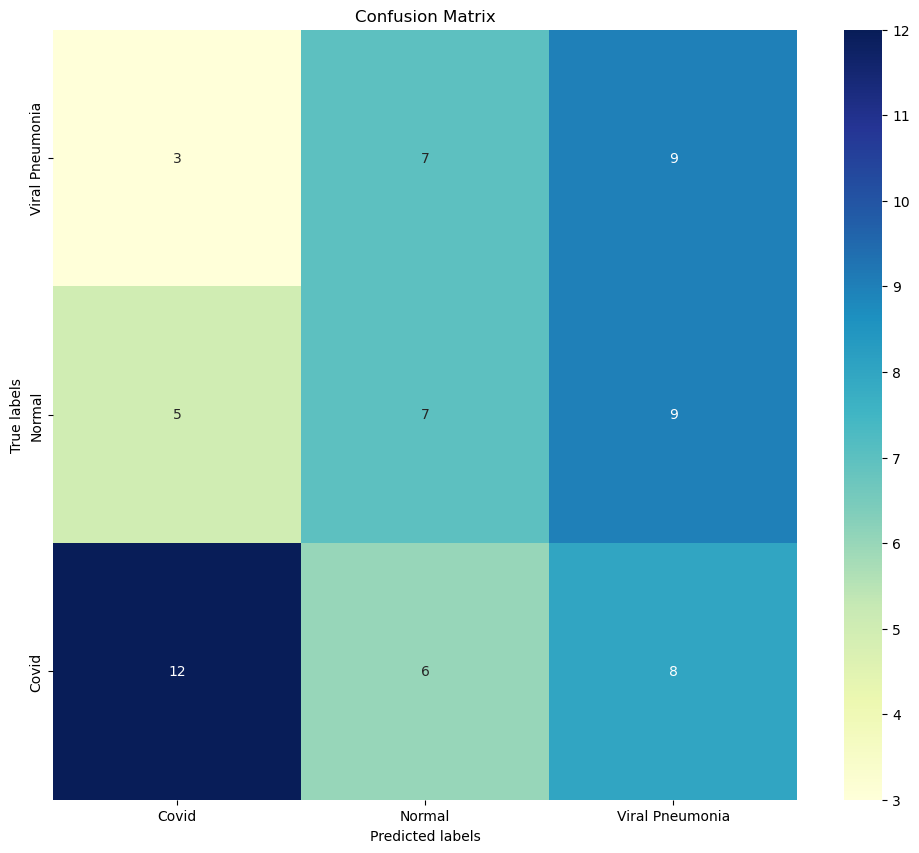

In [24]:
cal_score(model, 1)